In [1]:
import numpy as np
import keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers as l
from augmentation import *
from utils import *

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [29]:
%reload_ext tensorboard

## Dataset Preparation

In [2]:
X_train, y_train, X_test, y_test, enc_dict = load_dataset('../dataset_ts/ts_data_paa128.npz')

Porto le time series alla shape "channel last"

In [3]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)

"""
PER FARE AMPLITUDE SCALING, sono stati fatti dei test, alla fine NON UTILIZZATA

meann = np.mean(X_train, axis=-1, keepdims=True)
std = np.std(X_train, axis=-1, keepdims=True)
X_train = X_train - meann
X_train = X_train / std
"""

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

## Model Selection

In [14]:
class CNN_ts(k.Model):
  def __init__(self):
    super().__init__()

    self.conv1 = l.Conv1D(12, 9, activation='relu', data_format='channels_last')
    self.batchnorm1 = l.BatchNormalization(axis=-1)

    self.conv2 = l.Conv1D(24, 9, activation='relu', data_format='channels_last', kernel_regularizer=k.regularizers.l2(0.05))
    self.pool2 = l.MaxPooling1D(data_format='channels_last')
    self.drop = l.Dropout(0.55)
    self.batchnorm2 = l.BatchNormalization(axis=-1)
    

    self.conv3 = l.Conv1D(32, 9, activation='relu', data_format='channels_last', kernel_regularizer=k.regularizers.l2(0.05))
    self.pool3 = l.MaxPooling1D(data_format='channels_last')
    self.batchnorm3 = l.BatchNormalization(axis=-1)
    self.hdrop = l.Dropout(0.8)

    self.flat = l.Flatten()
    self.out = l.Dense(20, activation='softmax', kernel_regularizer=k.regularizers.l2(0.12))



  def call(self, x):
    # layer 1
    x = self.conv1(x)
    x = self.batchnorm1(x)

    # layer 2
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.batchnorm2(x)
    x = self.drop(x)

    # layer 3
    x = self.conv3(x)
    x = self.pool3(x)
    x = self.batchnorm3(x)
    x = self.hdrop(x)

    # layer 4
    x = self.flat(x)
    x = self.out(x)

    return x

In [16]:
model = CNN_ts()
model.compile(
    optimizer=k.optimizers.Adam(learning_rate=0.00005), # lr buono 0.00005
    loss=k.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [17]:
name = 'classic_v7'

In [2]:
#model.summary()

In [18]:
early_stopping = k.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=100,
    min_delta=0.0005,
    restore_best_weights=True
)

In [19]:
import datetime

log_dir = "logs/fit/" + name

tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
X_train_t = X_train[:6000]
y_train_t = y_train[:6000]

X_train_v = X_train[6000:]
y_train_v = y_train[6000:]



In [16]:
X_train_t.shape

(6000, 128, 1)

In [17]:
"""
PER FARE DATA AUGMENTATION, ALLA FINE NON UTILIZZATO (NONOSTANTE SEMBRASSE PROMETTENTE PER EVITARE L'OVERFITTING)

import random

#aug_model = tsgm.models.augmentations.WindowWarping()

r = random.choices(np.arange(0,6000,1), k = 1500)

for i in r:
  #print(X_train_t[i,:,:].shape)
  #new_ts = aug_model.generate(X=np.expand_dims(X_train_t[i],axis=0), n_samples=1, scales=(0.5,), window_ratio=0.5)
  new_ts = time_warp(x=np.expand_dims(X_train_t[i],axis=0))
  new_y = y_train_t[i]

  X_train_t = np.concatenate([X_train_t, new_ts], axis=0)
  y_train_t = np.concatenate([y_train_t, np.array([new_y])], axis=0)


"""

In [22]:
# alterno i due early stopping in base alla necessità, alla fine è stato utilizzato questo, più conservativo
long_early_stopping = k.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=600,
    min_delta=0.0001,
    restore_best_weights=True
)

In [11]:
save = k.callbacks.ModelCheckpoint(
    'nn_models/' + name,
    monitor="val_accuracy",
    mode='max',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch",
    initial_value_threshold=None,
)

In [23]:
# TRAINING LOOP PRINCIPALE
from keras import backend as kb

history = model.fit(
    x=X_train_t,
    y=y_train_t,
    epochs=3000,
    batch_size=256,
    validation_data=(X_train_v, y_train_v),
    callbacks=[tensorboard_callback, long_early_stopping]
)



Epoch 1/3000
24/24 [==============================] - 2s 37ms/step - loss: 11.7514 - accuracy: 0.0578 - val_loss: 11.1510 - val_accuracy: 0.0687
Epoch 2/3000
24/24 [==============================] - 1s 29ms/step - loss: 11.5092 - accuracy: 0.0582 - val_loss: 10.0768 - val_accuracy: 0.0580
Epoch 3/3000
24/24 [==============================] - 1s 26ms/step - loss: 11.3366 - accuracy: 0.0607 - val_loss: 9.6964 - val_accuracy: 0.0587
Epoch 4/3000
24/24 [==============================] - 1s 27ms/step - loss: 11.0681 - accuracy: 0.0638 - val_loss: 9.4930 - val_accuracy: 0.0753
Epoch 5/3000
24/24 [==============================] - 1s 25ms/step - loss: 10.7783 - accuracy: 0.0732 - val_loss: 9.3520 - val_accuracy: 0.0973
Epoch 6/3000
24/24 [==============================] - 1s 23ms/step - loss: 10.7125 - accuracy: 0.0733 - val_loss: 9.2412 - val_accuracy: 0.1067
Epoch 7/3000
24/24 [==============================] - 1s 25ms/step - loss: 10.4922 - accuracy: 0.0708 - val_loss: 9.1462 - val_accurac

In [56]:
# TRAINING LOOP SECONDARIO, da usare in caso serva addestrare per ulteriori epoche, nella versione finale NON UTILIZZATO
history2 = model.fit(
    x=X_train_t,
    y=y_train_t,
    epochs=3000,
    batch_size=256,
    validation_data=(X_train_v, y_train_v),
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/3000
24/24 [==============================] - 1s 30ms/step - loss: 1.9347 - accuracy: 0.4097 - val_loss: 2.0943 - val_accuracy: 0.3613
Epoch 2/3000
24/24 [==============================] - 1s 26ms/step - loss: 1.9417 - accuracy: 0.4072 - val_loss: 2.0946 - val_accuracy: 0.3633
Epoch 3/3000
24/24 [==============================] - 1s 26ms/step - loss: 1.9375 - accuracy: 0.4117 - val_loss: 2.0975 - val_accuracy: 0.3513
Epoch 4/3000
24/24 [==============================] - 1s 26ms/step - loss: 1.9444 - accuracy: 0.3992 - val_loss: 2.0927 - val_accuracy: 0.3687
Epoch 5/3000
24/24 [==============================] - 1s 25ms/step - loss: 1.9452 - accuracy: 0.3955 - val_loss: 2.0891 - val_accuracy: 0.3640
Epoch 6/3000
24/24 [==============================] - 1s 25ms/step - loss: 1.9414 - accuracy: 0.3977 - val_loss: 2.0925 - val_accuracy: 0.3687
Epoch 7/3000
24/24 [==============================] - 1s 24ms/step - loss: 1.9370 - accuracy: 0.4083 - val_loss: 2.0943 - val_accuracy: 0.3607

### Logs Plots

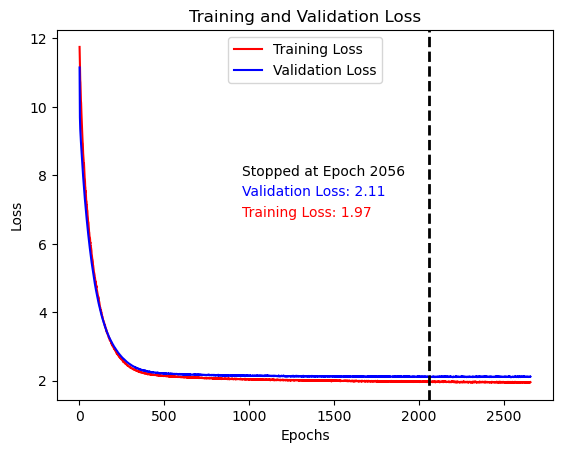

In [32]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, train_loss, label='Training Loss', c='red')
plt.plot(epochs, val_loss, label='Validation Loss', c='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=np.argmax(val_acc)+1, c='black', linestyle='--', linewidth=2)
plt.text(x=np.argmax(val_acc)-1100, y=8, s=f'Stopped at Epoch {np.argmax(val_acc)+1}')
plt.text(x=np.argmax(val_acc)-1100, y=7.4, s=f'Validation Loss: {round(val_loss[np.argmax(val_acc)], 2)}', c='blue')
plt.text(x=np.argmax(val_acc)-1100, y=6.8, s=f'Training Loss: {round(train_loss[np.argmax(val_acc)], 2)}', c='red')
plt.show()

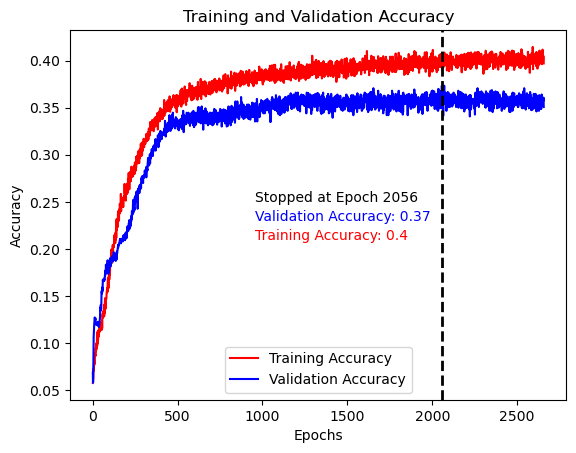

In [34]:
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
acc = history_dict['accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, train_acc, label='Training Accuracy', c='red')
plt.plot(epochs, val_acc, label='Validation Accuracy', c='blue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.axvline(x=np.argmax(val_acc)+1, c='black', linestyle='--', linewidth=2)
plt.text(x=np.argmax(val_acc)-1100, y=0.25, s=f'Stopped at Epoch {np.argmax(val_acc)+1}')
plt.text(x=np.argmax(val_acc)-1100, y=0.23, s=f'Validation Accuracy: {round(val_acc[np.argmax(val_acc)], 2)}', c='blue')
plt.text(x=np.argmax(val_acc)-1100, y=0.21, s=f'Training Accuracy: {round(train_acc[np.argmax(val_acc)], 2)}', c='red')
plt.show()

In [35]:
np.max(val_acc), np.argmax(val_acc)

(0.3733333349227905, 2055)

In [29]:
model.save_weights('nn_models/classic_final/final_model_128_weights')

In [36]:
np.savez('nn_models/classic_final/logs.npz', tot_acc=acc, tot_train_loss=train_loss, tot_val_acc=val_acc, tot_val_loss=val_loss)

## Validation Results

47/47 [==============================] - 0s 2ms/step


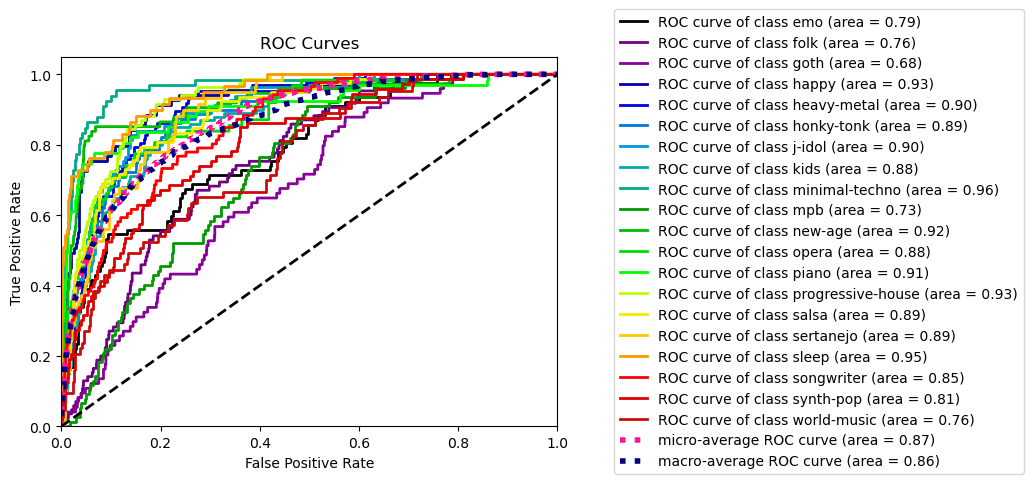

                   precision    recall  f1-score   support

              emo       0.28      0.14      0.19        77
             folk       0.09      0.02      0.04        85
             goth       0.00      0.00      0.00        74
            happy       0.57      0.46      0.51        69
      heavy-metal       0.43      0.47      0.45        87
       honky-tonk       0.34      0.46      0.39        79
           j-idol       0.35      0.47      0.40        81
             kids       0.36      0.35      0.35       100
   minimal-techno       0.68      0.61      0.64        66
              mpb       0.08      0.03      0.04        77
          new-age       0.49      0.50      0.50        74
            opera       0.38      0.34      0.36        62
            piano       0.60      0.64      0.62        67
progressive-house       0.48      0.46      0.47        84
            salsa       0.27      0.71      0.39        78
        sertanejo       0.23      0.58      0.32       

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc

y_prob = model.predict(X_train_v) 
y_pred = y_prob.argmax(axis=-1)
plot_roc(decode_y(y_train_v, enc_dict), y_prob)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()
print(classification_report(decode_y(y_train_v, enc_dict), decode_y(y_pred, enc_dict)))

## Test Results

In [38]:

y_prob = model.predict(X_test) 
y_pred = y_prob.argmax(axis=-1)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred, enc_dict)))

79/79 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

              emo       0.29      0.09      0.13       125
             folk       0.05      0.02      0.02       125
             goth       0.00      0.00      0.00       125
            happy       0.62      0.54      0.58       125
      heavy-metal       0.35      0.41      0.38       125
       honky-tonk       0.36      0.46      0.40       125
           j-idol       0.30      0.46      0.37       125
             kids       0.34      0.43      0.38       125
   minimal-techno       0.70      0.55      0.62       125
              mpb       0.08      0.02      0.03       125
          new-age       0.41      0.44      0.42       125
            opera       0.37      0.36      0.36       125
            piano       0.50      0.54      0.52       125
progressive-house       0.43      0.47      0.45       125
            salsa       0.22      0.62      0.33       125
  